In [1]:
# Import general libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Run to turn ON interactive visualization
%matplotlib tk

In [3]:
# Run to turn OFF interactive visualization
%matplotlib inline

In [4]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits
from auto_stretch import apply_stretch

# Load the image data
img_path = 'dataset/hst_skycell-p0048x16y13_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

# Stretch the image for better visualization
stretched_img = apply_stretch(raw_img)


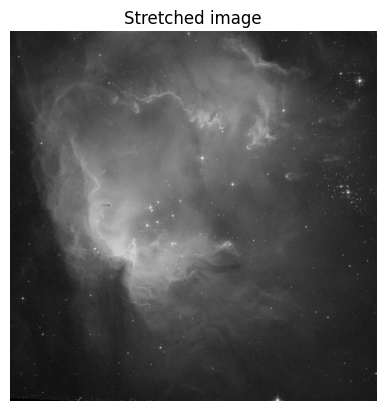

In [5]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched image')
plt.axis('off')
plt.show()

Core Concept
The algorithm removes blemishes by intelligently sampling from surrounding areas with similar characteristics, rather than using simple blurring or filling techniques.
Key Steps of the Algorithm

Create sampling circles: The code defines 6 sampling circles positioned at equal angles (0°, 60°, 120°, 180°, 240°, 300°) around the blemish area, each at 1.5× the blemish radius distance.
Select optimal source areas:

Calculates the median value for pixels in the blemish circle
Calculates median values for all six surrounding sampling circles
Identifies the three surrounding circles whose medians are closest to the blemish median
This ensures sampling from textures that best match the target area


Pixel-by-pixel healing process:

For each pixel in the blemish circle:

Calculates distance from the center to determine feathering weight
Samples corresponding pixels from the three selected circles
Calculates the median of these sampled values
Blends the median value with the original pixel using opacity and feathering




Blending formula:
blended_val = (1 - opacity × weight) × original_val + (opacity × weight) × median_val
Where:

weight varies from 0-1 based on distance and feathering parameter
opacity controls overall strength of the correction


Edge handling: The algorithm includes careful handling of edge cases when sampling circles extend beyond image boundaries.

This approach is similar to the "healing brush" in professional photo editing software, creating natural-looking repairs by intelligently replacing blemishes with textures sampled from similar surrounding areas, while ensuring smooth transitions through feathering and opacity controls.

In [6]:
import math

def calculate_median_circle(image, cx, cy, radius, channels):
        """
        Calculate the median value of a circle for the specified channels.

        Args:
            image (np.ndarray): The image array.
            cx (int): X-coordinate of the circle center.
            cy (int): Y-coordinate of the circle center.
            radius (int): Radius of the circle.
            channels (list): List of channel indices to process.

        Returns:
            float: The overall median value across specified channels.
        """
        values = []
        for c in channels:
            y_min = max(cy - radius, 0)
            y_max = min(cy + radius + 1, image.shape[0])
            x_min = max(cx - radius, 0)
            x_max = min(cx + radius + 1, image.shape[1])

            if image.ndim == 2:
                # Grayscale image (2D)
                roi = image[y_min:y_max, x_min:x_max]
            elif image.ndim == 3:
                if image.shape[2] ==1:
                    # Grayscale image with single channel
                    roi = image[y_min:y_max, x_min:x_max, 0]
                elif image.shape[2] >= c+1:
                    # RGB image
                    roi = image[y_min:y_max, x_min:x_max, c]
                else:
                    continue  # Skip if channel is out of bounds
            else:
                continue  # Unsupported image dimensions

            yy, xx = np.ogrid[:roi.shape[0], :roi.shape[1]]
            dist_from_center = np.sqrt((xx - (cx - x_min))**2 + (yy - (cy - y_min))**2)
            mask = dist_from_center <= radius
            values.extend(roi[mask].flatten())

        return np.median(values) if values else 0.0

def remove_blemish(image, x, y, radius, feather, opacity, channels_to_process):
    """
    Perform per-pixel blemish removal by sampling from surrounding circles.
    Handles edge cases where correction circles may extend beyond image boundaries.
    """
    corrected_image = image.copy()
    h, w = image.shape[:2]

    # Define angles for surrounding circles
    angles = [0, 60, 120, 180, 240, 300]
    surrounding_centers = []
    for angle in angles:
        rad = math.radians(angle)
        dx = int(math.cos(rad) * (radius * 1.5))  # 1.5 times the radius away
        dy = int(math.sin(rad) * (radius * 1.5))
        surrounding_centers.append((x + dx, y + dy))

    # Calculate medians for each surrounding circle and the target circle
    target_median = calculate_median_circle(image, x, y, radius, channels_to_process)
    surrounding_medians = [
        calculate_median_circle(image, cx, cy, radius, channels_to_process)
        for cx, cy in surrounding_centers
    ]

    # Determine the three correction circles closest to the target median
    median_diffs = [abs(median - target_median) for median in surrounding_medians]
    closest_indices = np.argsort(median_diffs)[:3]  # Indices of the three closest circles
    selected_circles = [surrounding_centers[i] for i in closest_indices]

    # Iterate through each channel
    for c in channels_to_process:
        # Iterate through each pixel in the target blemish circle
        for i in range(max(y - radius, 0), min(y + radius + 1, h)):
            for j in range(max(x - radius, 0), min(x + radius + 1, w)):
                dist = math.sqrt((j - x) ** 2 + (i - y) ** 2)
                if dist <= radius:
                    # Apply feathering based on distance
                    if feather > 0:
                        weight = max(0, min(1, (radius - dist) / (radius * feather)))
                    else:
                        weight = 1

                    # Collect corresponding pixel values from the selected correction circles
                    sampled_values = []
                    for (cx, cy) in selected_circles:
                        # Find the corresponding pixel position
                        corresponding_j = j + (cx - x)
                        corresponding_i = i + (cy - y)

                        # Ensure the corresponding pixel is within image bounds
                        if 0 <= corresponding_i < h and 0 <= corresponding_j < w:
                            if image.ndim == 2:
                                sampled_values.append(image[corresponding_i, corresponding_j])
                            elif image.ndim == 3:
                                if image.shape[2] == 1:
                                    sampled_values.append(image[corresponding_i, corresponding_j, 0])
                                elif image.shape[2] > c:
                                    sampled_values.append(image[corresponding_i, corresponding_j, c])
                                else:
                                    continue  # Skip if channel is out of bounds

                    if sampled_values:
                        # Calculate the median of the sampled values
                        median_val = np.median(sampled_values)
                    else:
                        # If no valid sampled pixels, retain the original pixel value
                        if image.ndim == 2:
                            median_val = image[i, j]
                        elif image.ndim == 3 and image.shape[2] ==1:
                            median_val = image[i, j,0]
                        else:
                            median_val = image[i,j,c]

                    # Blend the median value into the target pixel using opacity and feathering
                    if image.ndim ==2:
                        original_val = image[i, j]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j] = blended_val
                    elif image.ndim ==3 and image.shape[2] ==1:
                        original_val = image[i, j,0]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j,0] = blended_val
                    elif image.ndim ==3 and image.shape[2] >c:
                        original_val = image[i, j, c]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j, c] = blended_val

    return corrected_image

In [7]:
# INPAINTING FOR A SMALL STAR
# Radius = 15
# Feather = 0.5
# Opacity = 0.95
small_star_inpainted = remove_blemish(image=stretched_img, x=1460, y=4447, radius=15, feather=0.5, opacity=0.95, channels_to_process=[0])

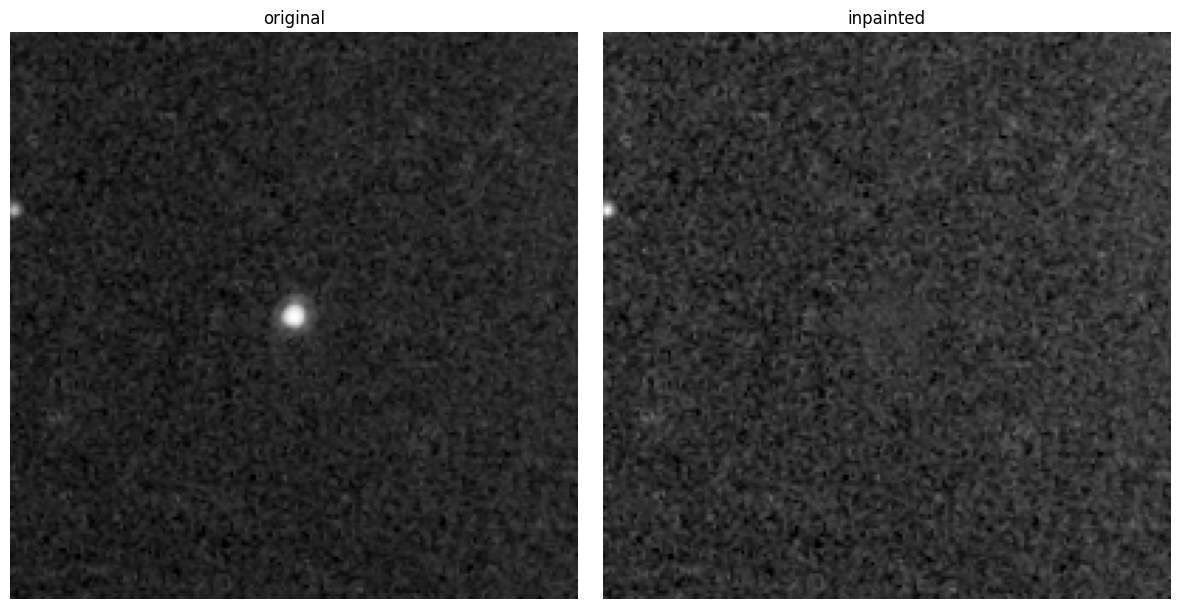

In [8]:
# Show result
half_size = 100
x, y = 1460, 4447

patch_original = stretched_img[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]
patch_inpainted = small_star_inpainted[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 
axes[0].imshow(patch_original, cmap='gray')
axes[0].set_title('original')
axes[0].axis('off')

# 
axes[1].imshow(patch_inpainted, cmap='gray')
axes[1].set_title('inpainted')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# INPAINTING FOR A BIG STAR: (x,y) = (4686, 668)
# Radius = 135
# Feather = 0.5
# Opacity = 0.95
big_star_inpainted_r = remove_blemish(image=stretched_img, x=4686, y=668, radius=135, feather=0.5, opacity=1, channels_to_process=[0])

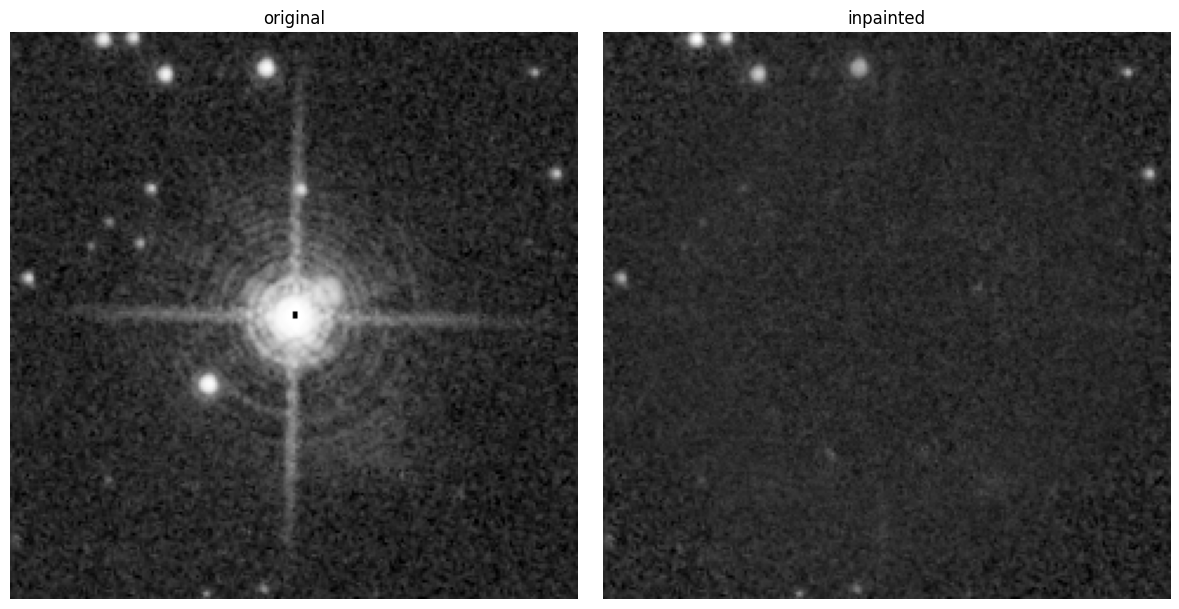

In [10]:
# Show result
half_size = 120
x, y = 4686, 668

patch_original = stretched_img[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]
patch_r = big_star_inpainted_r[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]

# patch_inpainted = small_star_inpainted[y - half_size : y + half_size + 1,
#               x - half_size : x + half_size + 1]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 
axes[0].imshow(patch_original, cmap='gray')
axes[0].set_title('original')
axes[0].axis('off')

# 
axes[1].imshow(patch_r, cmap='gray')
axes[1].set_title('inpainted')
axes[1].axis('off')

plt.tight_layout()
plt.show()